In [1]:
import TraceDisplay as TD
from TraceDisplay import BOKEH_RENDERER
import os
from IPython.core.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt

Loading BokehJS ...

In [2]:
# Chose a .tar
path_to_tar = ! find ../trace -name *.tar | grep -E 'BENCH=kbuild-sched.*GOVERNOR=schedutil.*MONITORING=trace-cmd.*local' | head -n 1
path_to_tar = path_to_tar[0]
path_to_tar

'../trace/HOST=ryzen/BENCH=kbuild-sched/CMDLINE=default/GOVERNOR=schedutil/MONITORING=trace-cmd/16-5.4-local/1.tar'

In [3]:
# Get its .h5
path_to_h5 = os.path.splitext(path_to_tar[len('../trace/'):])[0] + '.h5'
path_to_dat = os.path.splitext(path_to_h5)[0] + '.dat'
trace = TD.Trace()
if os.path.exists(path_to_h5):
    trace.load(path_to_h5)
else:
    # Extract .dat and convert to .h5
    ! mkdir -p $(! dirname $path_to_dat)
    path_trace_dat_tgz = ! tar tf $path_to_tar | grep trace.dat.tgz | head -n 1
    path_trace_dat_tgz=path_trace_dat_tgz[0]
    path_trace_dat = ! tar -O -xf $path_to_tar $path_trace_dat_tgz | tar ztf - | grep trace.dat | head -n 1
    path_trace_dat = path_trace_dat[0]
    ! tar -O -xf $path_to_tar $path_trace_dat_tgz | tar -O -xzf - $path_trace_dat > $path_to_dat
    trace.load(path_to_dat)
    trace.save(path_to_h5)
    os.remove(path_to_dat)
trace.keys()

['/sched_wake_idle_without_ipi',
 '/sched_wakeup_new',
 '/sched_waking',
 '/sched_process_wait',
 '/sched_process_exec',
 '/sched_wakeup',
 '/sched_rq_size_change',
 '/sched_process_free',
 '/sched_switch',
 '/sched_process_fork',
 '/sched_tick',
 '/sched_migrate_task',
 '/sched_process_exit',
 '/sched_stat_runtime']

In [4]:
# Shift timestamps
tmin = min([min(trace[k].index) for k in trace])
tmax = max([max(trace[k].index) for k in trace])
print((tmax-tmin)/1e9)
for k in trace:
    trace[k].index = trace[k].index - tmin

7.100694107


In [5]:
def sched_tick(df):
    import numpy as np
    df = df['sched_tick']
    timestamp = np.array(df.index, dtype=float)
    cpu = np.array(df['cpu'], dtype=float)
    freq = np.array(df['freq'], dtype=float)
    return {
        'x0' : timestamp,
        'x1' : timestamp,
        'y0' : cpu,
        'y1' : cpu + 0.5,
        'freq' : freq,
    }
shapes = [('sched_tick',sched_tick)]

In [6]:
image = TD.Image()
image.build(trace, shapes)
ci = TD.ColoredImage(image)
HTML(ci.html_legend())

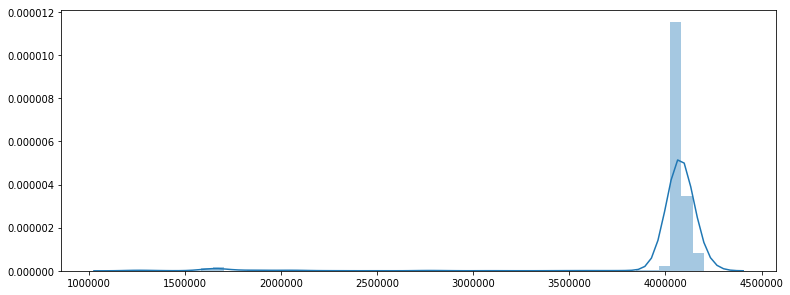

In [7]:
freq = ci.df['sched_tick']['freq'].values
fig = plt.figure(figsize=(6.4*2, 4.8))
sns.distplot(freq);

In [8]:
# Change color[0] and add more colors
ci.color_map[0].label = 'freq < 2GHz'
ci.color_map[0].query = {'sched_tick':'freq < 2000000'}
ci.addColor(label='2GHz < freq < 4GHz', query={'sched_tick':'freq<4000000 & freq > 2000000'})
ci.addColor(label='freq > 4GHz', query={'sched_tick':'freq>4000000'})
ci.applyColor()
HTML(ci.html_legend())

In [9]:
br = TD.BokehRenderer()
br.show()

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEJ1dHRvbihkZXNjcmlwdGlvbj11J1J1biBJbnRlcmFjdCcsIHN0eWxlPUJ1dHRvblN0eWxlKCkpLCBPdXRwdXQoKSksIF9kb21fY2xhc3Nlcz0odSd3aWTigKY=


(1295786.0, 7097959925.0)
(0, 7.5)


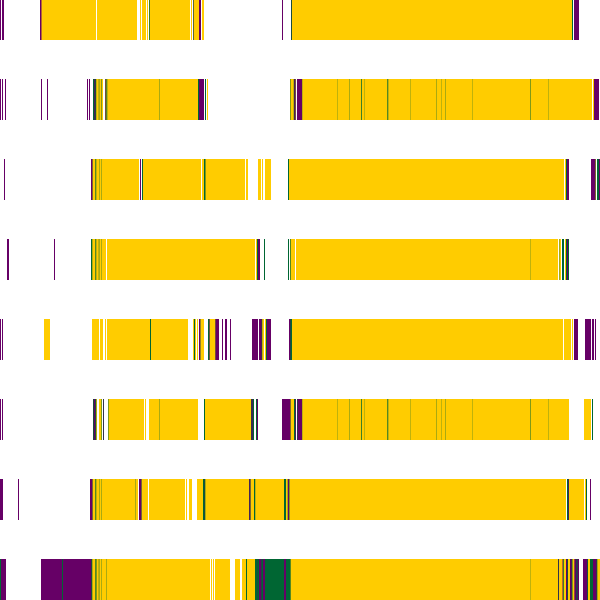

In [10]:
br.render(ci)
display(br.image)